In [1]:
#https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/

#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/006%20Time%20Series%20Forecasting%20-%20Multi-Output%20Regression.ipynb

# Step #1 Load the Data

In [2]:
# Time Series Forecasting - Multi-output Regression for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
import time
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data

import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training


import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
 
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
# from keras.layers import Flatten,Dropout    
    
import seaborn as sns


# check the tensorflow version and the number of available GPUs
# print('Tensorflow Version: ' + tf.__version__)
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs:", len(physical_devices))



In [16]:
ab_path = "../data/SPY-Daily-Y09-Now.csv"
stockname='SPY'

start_date='2016-01-01'
end_date='2022-12-31'

date_col='Date'
prediction_col='SIGNAL'
# feature_cols=['Price','EMA1','MACD','RSI']
feature_cols=['SIGNAL']

split_way=2

input_sequence_length =120
output_sequence_length = 15
train_ratio=0.8

n_epochs = 100
n_batch_size = 32
n_early=6

tune_folder='multivar_tune'

seed=99

In [17]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']


In [18]:
df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2016-01-04 to 2022-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SIGNAL  1761 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB
None


,SIGNAL
Date,
2022-12-22,0.37
2022-12-23,-0.07
2022-12-27,-0.47
2022-12-28,-0.88
2022-12-29,-1.20


# Step #2 Exploring the Data

In [19]:
ncols = 1
nrows = len(feature_cols)

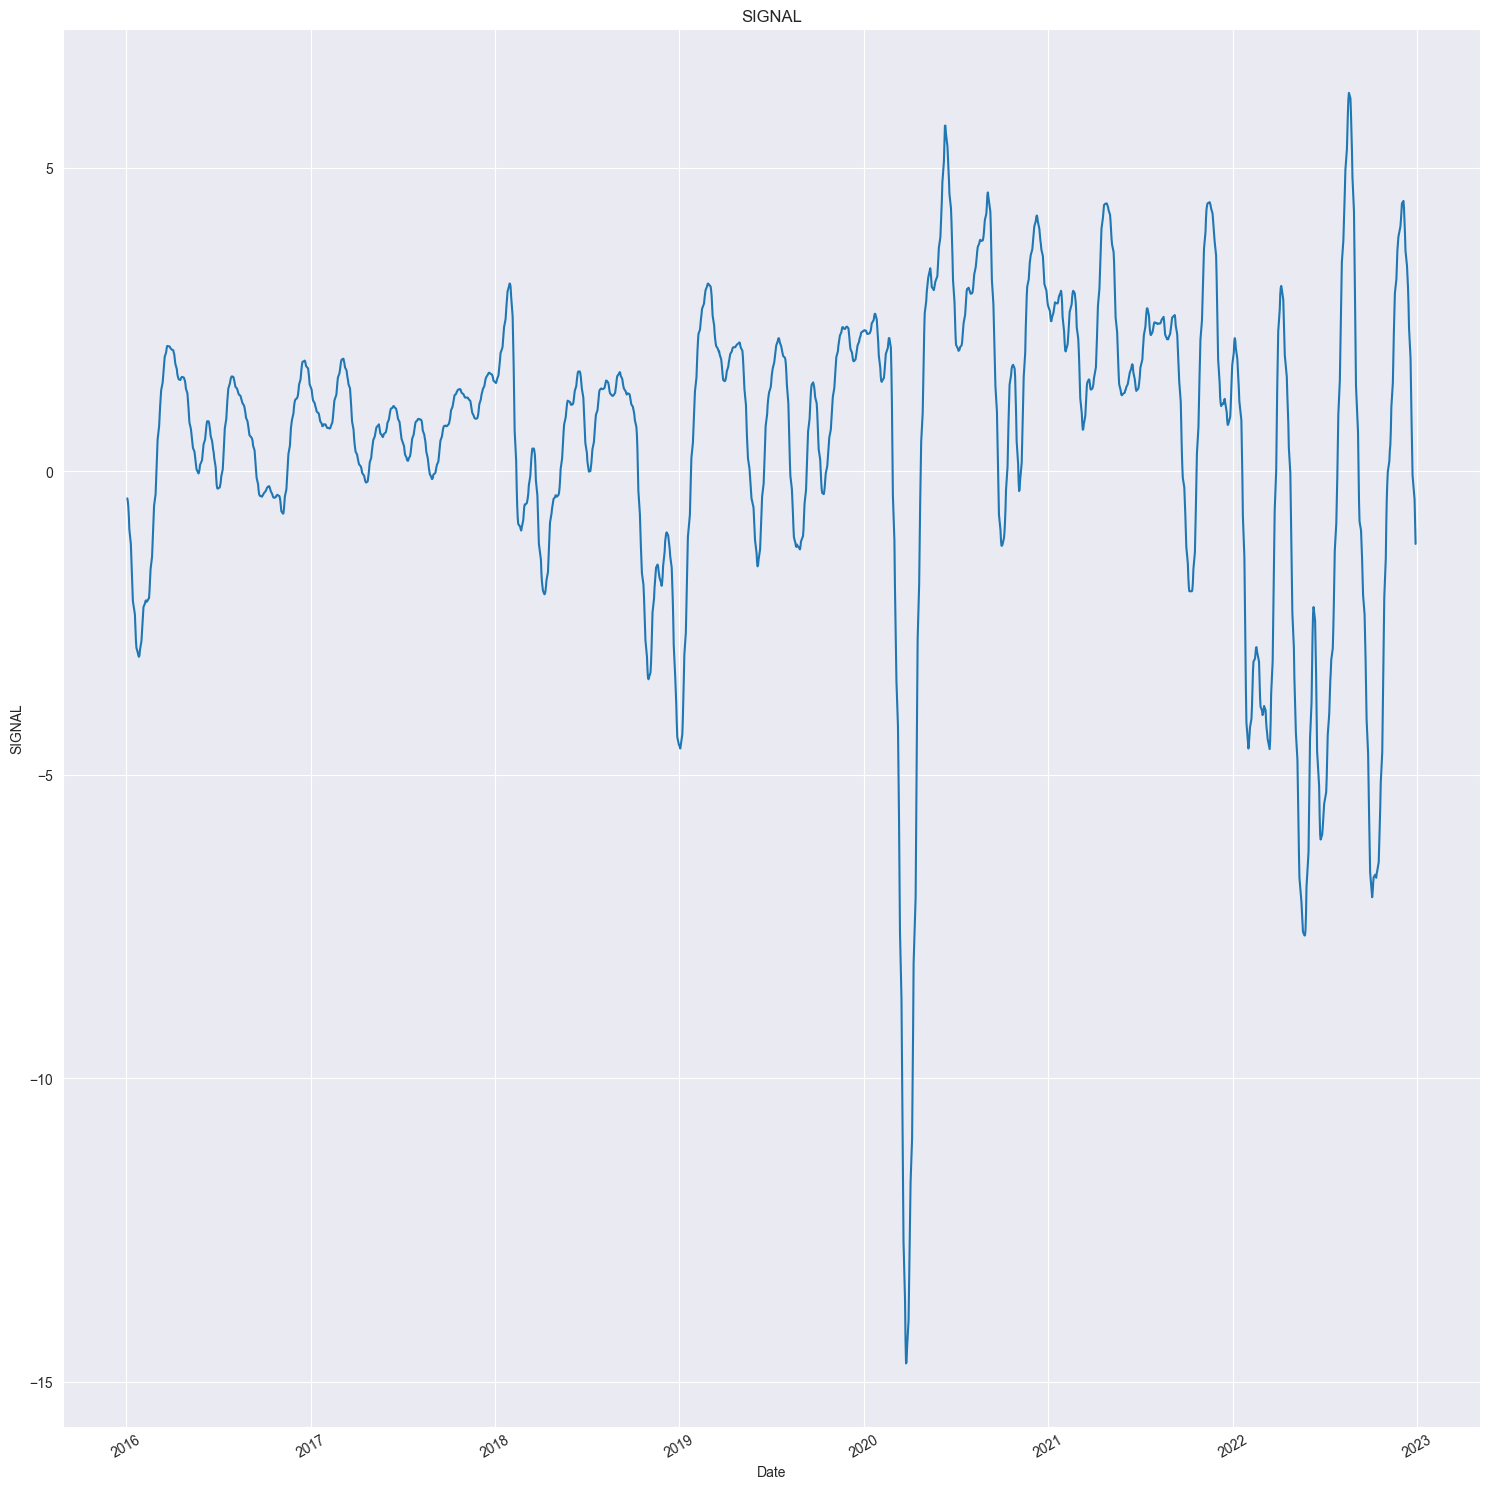

In [20]:
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [21]:
# Indexing Batches
df_train = df.sort_values(by=[date_col]).copy()
df_train.shape

(1761, 1)

In [22]:
def prepare_data(df):

    # List of considered Features
    FEATURES = feature_cols

    print(f'FEATURE LIST To Predict {prediction_col}')
    print([f for f in FEATURES])

    #Create the dataset with features and filter the data to the list of FEATURES"
    df_filter = df[FEATURES]
    
    print("Convert the data to numpy values")
    np_filter_unscaled = np.array(df_filter)
    np_filter_unscaled = np.reshape(np_filter_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)
    
    np_c_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_c_unscaled.shape)
    
    return np_filter_unscaled, np_c_unscaled

np_filter_unscaled, np_c_unscaled = prepare_data(df_train)   


print("Feature Data",np_filter_unscaled.shape)
print(np_filter_unscaled[:3])
print("Prediction Data",np_c_unscaled.shape)
print(np_c_unscaled[:3])

FEATURE LIST To Predict SIGNAL
['SIGNAL']
Convert the data to numpy values
(1761, 1)
(1761, 1)
Feature Data (1761, 1)
[[-0.45]
 [-0.5 ]
 [-0.59]]
Prediction Data (1761, 1)
[[-0.45]
 [-0.5 ]
 [-0.59]]


In [23]:
print(f"{input_sequence_length} = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction")
print(f"{output_sequence_length} = The output sequence length is the number of steps that the neural network predicts")

#How much ratio to split
index_Close = df_train.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Close}")

# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_filter_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

120 = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction
15 = The output sequence length is the number of steps that the neural network predicts
Prediction Index = 0
0.8 = 1409 Split the training data into train and train data sets


In [24]:
print("Creating a separate scaler that works on a single column for scaling predictions")
print("Scale each feature to a range between 0 and 1")
scaler_train = MinMaxScaler()
print("Create a separate scaler for a single column")
scaler_pred = MinMaxScaler()


if split_way==1:
    print("Way#1 scale entire data and split data")   
    
    np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)
    
    print("All Data scaled for creating train and test data")    
    print(np_scaled.shape,np_scaled_c.shape)
    print(np_scaled_c[:5],np_scaled_c[:5])
    
    # Create the training and test data
    train_data =np_scaled[0:train_data_length, :]
    test_data = np_scaled[train_data_length - input_sequence_length:, :]

else:
    print("#Way#2 split data and apply  only train to scale")
    
    train_data = np_filter_unscaled[0:train_data_length, :]
    test_data = np_filter_unscaled[train_data_length - input_sequence_length:, :]

    np_PredictVal_unScaled=np_c_unscaled[0:train_data_length]
    
    print("Train Data to be scaled") 
    print(train_data.shape,np_PredictVal_unScaled.shape)
    print(train_data[:5],np_PredictVal_unScaled[:5])
    
    train_data=scaler_train.fit_transform(train_data)
    test_data=scaler_train.transform(test_data)
    
    print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
    np_scaled=scaler_train.transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_PredictVal_unScaled)
    
    print("Predict val data(Scaled from Train data")
    print(np_scaled_c.shape)
    print(np_scaled_c[:3])
print("=========================================")       
print("Scaled data completely")
print("train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:3])
print(test_data[:3])



Creating a separate scaler that works on a single column for scaling predictions
Scale each feature to a range between 0 and 1
Create a separate scaler for a single column
#Way#2 split data and apply  only train to scale
Train Data to be scaled
(1409, 1) (1409, 1)
[[-0.45]
 [-0.5 ]
 [-0.59]
 [-0.74]
 [-0.96]] [[-0.45]
 [-0.5 ]
 [-0.59]
 [-0.74]
 [-0.96]]
For predict test that take the past 120 train value to predict the first test value
Predict val data(Scaled from Train data
(1409, 1)
[[0.698872  ]
 [0.69641981]
 [0.69200589]]
Scaled data completely
train and test data
(1409, 1) (472, 1)
[[0.698872  ]
 [0.69641981]
 [0.69200589]]
[[0.86169691]
 [0.86512997]
 [0.86660128]]


In [25]:
print("The RNN needs data with the format of [samples, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation ,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The RNN needs data with the format of [samples, time steps, features]


In [26]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and f features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



Here, we create 1409 samples, input_sequence_length time steps per sample, and f features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(1274, 120, 1) (1274, 15)
(337, 120, 1) (337, 15)


# Step #4 Model Training

In [27]:
# Configure the neural network model
print(f"Train Row : {x_train.shape[0]}")

# tf.random.set_seed(7)

model = Sequential()
n_output_neurons = output_sequence_length


      
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]

#n_input_neurons50
neuron_number =inputshape_Timestamps * no_feature

print("Start neron number=",neuron_number)    
    


Train Row : 1274
Start neron number= 120


In [28]:
max_neuron=300
step_neuron=30

In [30]:
# 3 basic Model Design
# if way==1:
#  model.add(LSTM(100, return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
# elif way==2:
#  model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(inputshape_Timestamps,no_feature))) 
#  model.add(LSTM(n_input_neurons, return_sequences=False))
# else:
#     model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(inputshape_Timestamps, no_feature))) 
#     model.add(Dropout(0.2))
#     model.add(LSTM(n_input_neurons, return_sequences=False))
#     model.add(Dropout(0.2))  

def my_way_build_model(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
    # if IsDropOut:
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))

    model.add(Dense(n_output_neurons))

    model.compile(optimizer="adam", loss="mean_squared_error",metrics = ['mse'])

    return model

In [31]:
def build_model_way1(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))

    model.add(Dense(n_output_neurons))

    model.compile(optimizer="adam", loss="mean_squared_error",metrics = ['mse'])

    return model


# Way2 Multiple Layer and Dropput layer LSTM
def build_model_way2(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 5)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=neuron_number,max_value=max_neuron,step=step_neuron) \
                  ,return_sequences=True))       
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=neuron_number,max_value=maxlast_neuron,step=step_neuron) \
                  ,return_sequences=False ))
        
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)))

    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mean_squared_error",metrics = ['mse'])

    return model


# Way2 3 Layer and 2 Dropput layer LSTM
def build_model_way3(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
   
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)))
    
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=neuron_number,max_value=max_neuron,step=step_neuron) \
                  ,return_sequences=False ))
        
    model.add(Dropout(hp.Float('Dropout_2_rate',min_value=0,max_value=0.4,step=0.1)))

    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mean_squared_error",metrics = ['mse'])

    return model

In [32]:
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"multivar_myway{buildtime}"
print(project_model)

multivar_myway311222_2038


In [33]:

t_Start=time.time()

print(f"Start tund at {datetime.now()}")

Start tund at 2022-12-31 20:38:19.448950


In [35]:
early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        my_way_build_model,
        objective='mse',
        max_trials=5,
        seed=seed,
        # executions_per_trial=4,
        directory=f"{tune_folder}/",
        project_name= project_model
        
   
        )
tuner.search(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs,
                        validation_data=(x_test, y_test),
                        shuffle=False,verbose=1,callbacks=[early_stop])

tuner.results_summary()

Trial 5 Complete [00h 06m 57s]
mse: 0.005123450420796871

Best mse So Far: 0.003655540756881237
Total elapsed time: 00h 30m 01s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in multivar_tune/multivar_myway311222_2038
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 180
Dropout_rate: 0.1
Score: 0.003655540756881237
Trial summary
Hyperparameters:
input_unit: 210
Dropout_rate: 0.1
Score: 0.0041253031231462955
Trial summary
Hyperparameters:
input_unit: 120
Dropout_rate: 0.2
Score: 0.004352211952209473
Trial summary
Hyperparameters:
input_unit: 180
Dropout_rate: 0.4
Score: 0.005123450420796871
Trial summary
Hyperparameters:
input_unit: 150
Dropout_rate: 0.0
Score: 0.005431389901787043


In [36]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  1.09
2022-12-31 21:44:01.410297


In [37]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model=tuner.get_best_models(num_models=1)[0]
#model = tuner.hypermodel.build(best_hps)
print(best_hps.values)

# model_x = tuner.get_best_models(num_models=1)[0]
model.summary()

{'input_unit': 180, 'Dropout_rate': 0.1}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180)               131040    
                                                                 
 dropout (Dropout)           (None, 180)               0         
                                                                 
 dense (Dense)               (None, 15)                2715      
                                                                 
Total params: 133,755
Trainable params: 133,755
Non-trainable params: 0
_________________________________________________________________


# Training the TUNE Model to Get history

In [24]:
print(f"Training the TUNE Model")
t_Start=time.time()
print(datetime.now())

if n_early==0:

 history = model.fit(x_train, y_train, 
                batch_size=n_batch_size,
                epochs=n_epochs,
                shuffle=False,
                validation_data=(x_test, y_test),
                verbose=2
               )
else:
    early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
                    
    history = model.fit(x_train, y_train, 
                    batch_size=n_batch_size, 
                    epochs=n_epochs,
                    shuffle=False,
                    validation_data=(x_test, y_test),
                    verbose=2,callbacks=[early_stop]
                   )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training the TUNE Model
2022-12-30 23:25:53.862611
Epoch 1/100
42/42 - 7s - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0274 - val_mse: 0.0274 - 7s/epoch - 163ms/step
Epoch 2/100
42/42 - 4s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0267 - val_mse: 0.0267 - 4s/epoch - 103ms/step
Epoch 3/100
42/42 - 4s - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0258 - val_mse: 0.0258 - 4s/epoch - 103ms/step
Epoch 4/100
42/42 - 4s - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0247 - val_mse: 0.0247 - 4s/epoch - 102ms/step
Epoch 5/100
42/42 - 4s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0236 - val_mse: 0.0236 - 4s/epoch - 100ms/step
Epoch 6/100
42/42 - 4s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0224 - val_mse: 0.0224 - 4s/epoch - 101ms/step
Epoch 7/100
42/42 - 4s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0212 - val_mse: 0.0212 - 4s/epoch - 100ms/step
Epoch 8/100
42/42 - 4s - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0200 - val_mse: 0.0200 - 4s/epoch - 100ms/step
Epoch 9/100
42/42 - 4s - loss: 0.0065 - mse: 

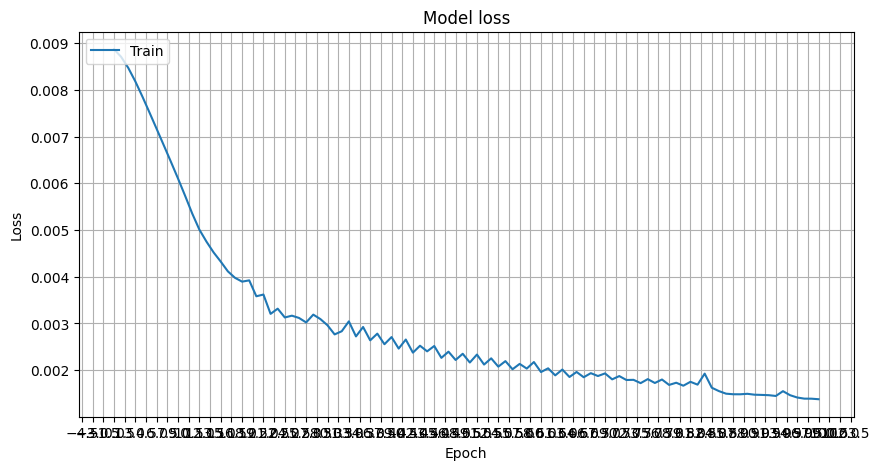

In [27]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

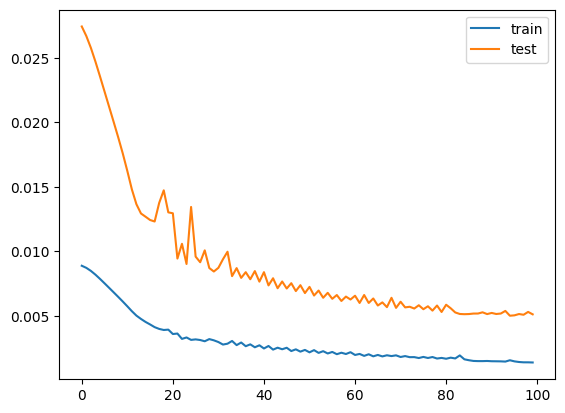

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [29]:
# import shap

# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, x_train)
# shap_values = explainer.shap_values(x_test)

# Step #5 Evaluate Model Performance

In [38]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

11/11 [==============================] - 2s 53ms/step
(337, 15)
(337, 15)
(337, 15)


In [39]:
RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')




Root MEAN Square Error(RMSE): 2.29
Mean Absolute Error (MAE): 1.68
Median Absolute Error (MAE): 1.68
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 46.25 %


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10124\4124666818.py:14: RuntimeWarning: divide by zero encountered in divide
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10124\4124666818.py:18: RuntimeWarning: divide by zero encountered in divide
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100


# Plot Multiple Forcast (Most Complex Step)

In [40]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = stockname + "_stock_price_quotes")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



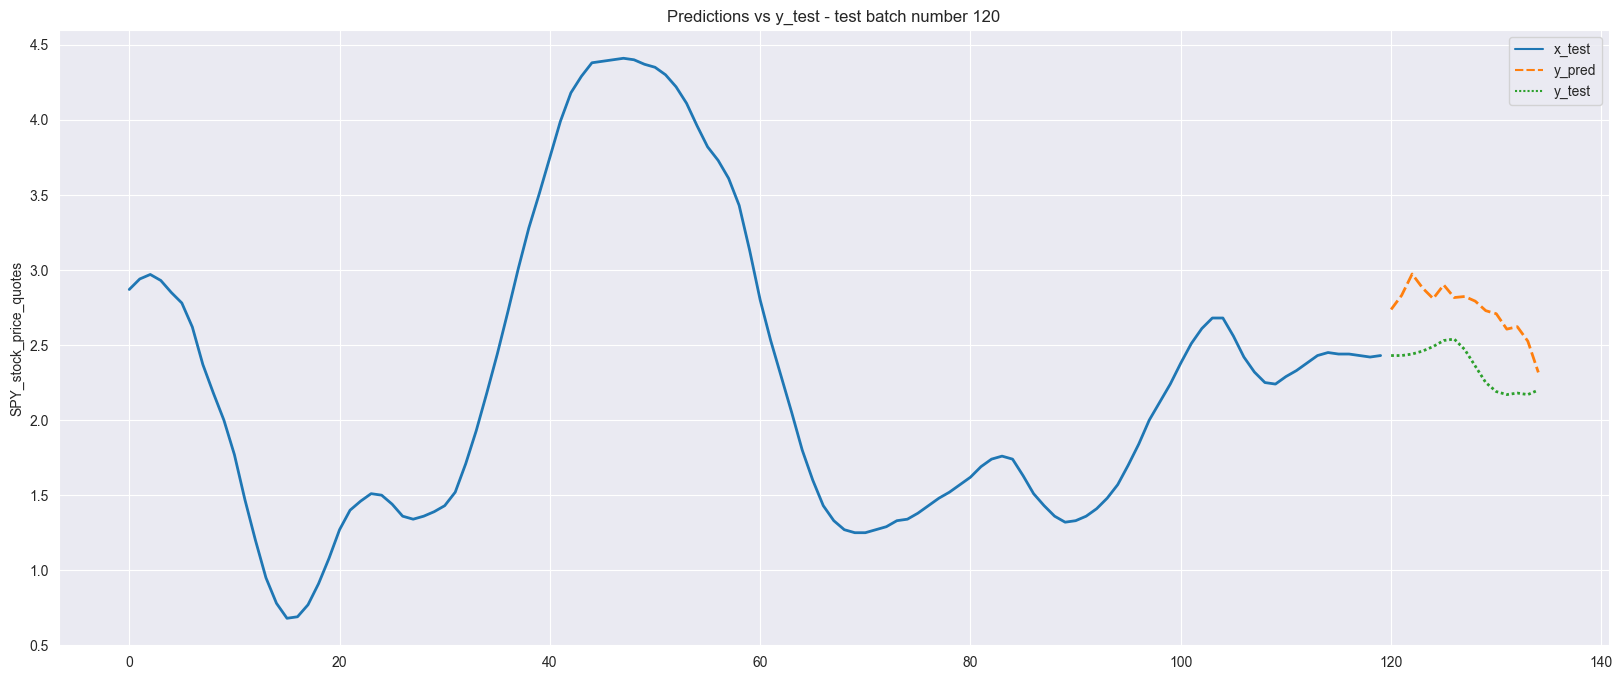

In [41]:
# Creates a linechart for a specific test batch_number and corresponding test predictions

x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(i, x_test, y_test, y_pred)
title = f"Predictions vs y_test - test batch number {input_sequence_length}"
plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 

# Step #6 Create a new Forecast

In [34]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

    
x_test_latest_batch

(1, 80, 1) is the latest input batch from the test dataset, which is contains the price values for the last 80 trading days


array([[[0.75232957],
        [0.72094164],
        [0.69641981],
        [0.68023541],
        [0.67287886],
        [0.66208926],
        [0.65080922],
        [0.637077  ],
        [0.62089259],
        [0.60519863],
        [0.58803335],
        [0.56841589],
        [0.54634625],
        [0.52035311],
        [0.49239823],
        [0.46395292],
        [0.4409024 ],
        [0.41883276],
        [0.39676312],
        [0.38106915],
        [0.37665522],
        [0.38057872],
        [0.38793526],
        [0.39283963],
        [0.39480137],
        [0.39431094],
        [0.39234919],
        [0.39578225],
        [0.39774399],
        [0.40510054],
        [0.41834232],
        [0.43403629],
        [0.44923982],
        [0.46885728],
        [0.49386954],
        [0.52427661],
        [0.55566454],
        [0.5860716 ],
        [0.61893085],
        [0.65031878],
        [0.67925454],
        [0.69936243],
        [0.71162334],
        [0.7204512 ],
        [0.72878862],
        [0

In [42]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

NameError: name 'x_test_latest_batch' is not defined

In [43]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions


NameError: name 'x_test_latest_batch' is not defined

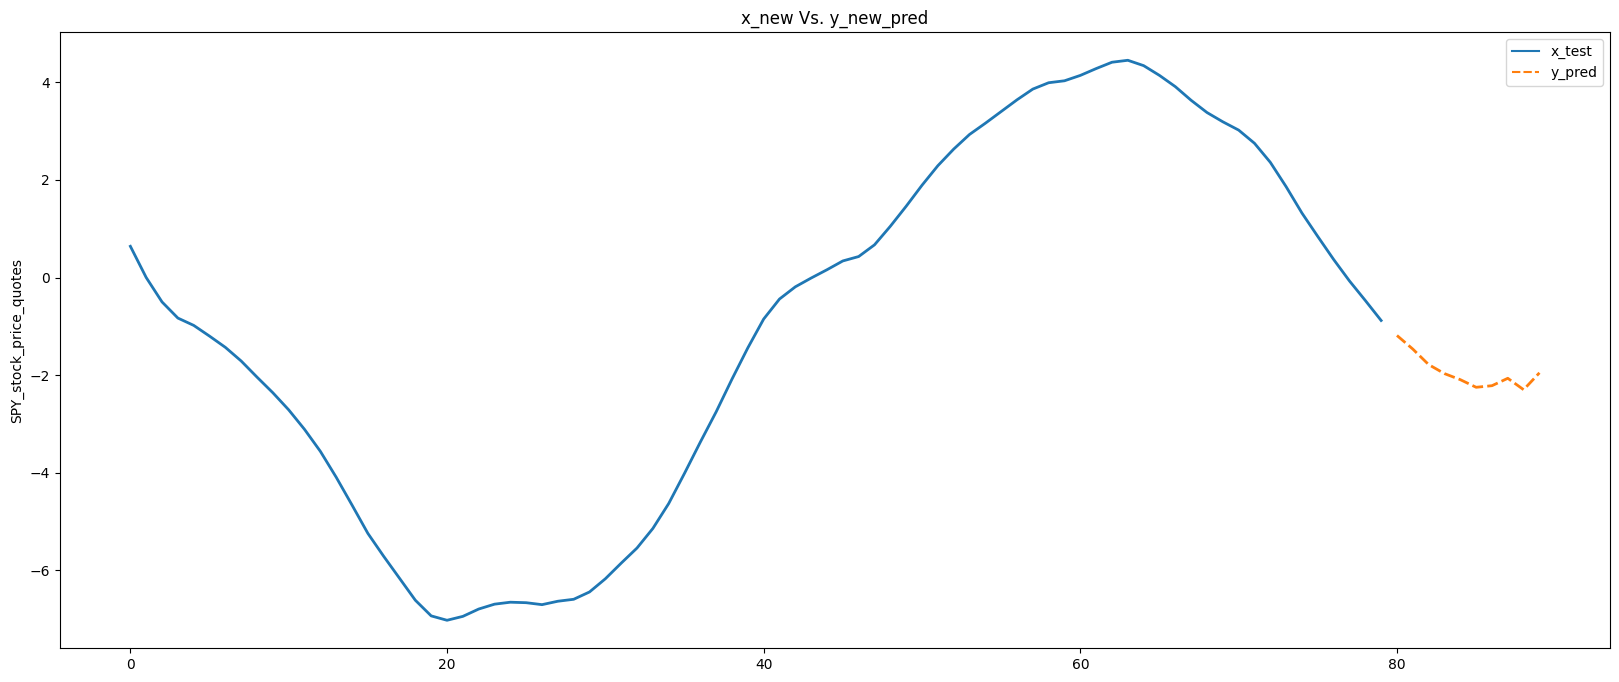

In [38]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")